In [24]:

import os
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm, tnrange
import matplotlib.pyplot as plt
import time
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_score, confusion_matrix, f1_score, accuracy_score, recall_score, classification_report, roc_auc_score, auc, roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
import xgboost as xgb
import pickle

tqdm.pandas()

In [28]:
label_dic = {0: 'Bag', 1: 'Hand', 2: 'Hips', 3: 'Torso'}


def evaluate(y_true, y_pred, class_names=list(label_dic.values())):
    #各种评价指标
    print('Macro F1 Score: {}\n'.format(
        f1_score(y_true, y_pred, average='macro')))
    print(classification_report(y_true, y_pred, target_names=class_names))

    #绘制混淆矩阵热力图
    conf = confusion_matrix(y_true, y_pred)
    print(conf)
    plt.figure(figsize=(9, 8))
    sns.heatmap(conf,
                cmap=plt.cm.Blues,
                annot=True,
                fmt="d",
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predict label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix', fontsize=16)
    plt.show()

In [2]:
def rename_columns(dataframe,common_part):
    """去掉给定数据框中给定的列的公共部分

    Args:
        dataframe (str): 数据集
        common_part (str): 公共部分
    """
    dataframe.columns=[col.replace(common_part, '') for col in dataframe.columns]
    
def matching_columns(dataframe,common_part):
    """匹配给定数据框中具有给定公共部分的所有的列

    Args:
        dataframe (str): 数据集
        common_part (str): 公共部分
    """
    matching_columns = [col for col in dataframe.columns if common_part in col]
    print('找到的列的数量为： {}'.format(len(matching_columns)))
    return matching_columns

# 加载数据集

In [29]:
data1_1 = pd.read_pickle('/home/ossdata/dengjiebi/data_full/train/bag_acc.pkl')
data1_2 = pd.read_pickle('/home/ossdata/dengjiebi/data_full/train/bag_gps_and_loc.pkl')
data1_3 = pd.read_pickle('/home/ossdata/dengjiebi/data_full/train/bag_gyr.pkl')
data1_4 = pd.read_pickle('/home/ossdata/dengjiebi/data_full/train/bag_mag.pkl')
data1_5 = pd.read_pickle('/home/ossdata/dengjiebi/data_full/train/bag_speed.pkl')
data1_6 = pd.read_pickle('/home/ossdata/dengjiebi/data_full/train/bag_distance.pkl')
label1 = pd.read_pickle('/home/ossdata/dengjiebi/data_tiny/train/label.pkl')

X1=pd.concat([data1_1, data1_2,data1_3,data1_4,data1_5,data1_6],axis=1)
rename_columns(X1,'bag_')
y1=label1.copy()
y1['label_pos']=0
X1.head(5)

,acc_Acc_x,acc_Acc_y,acc_Acc_z,acc_L2,Mean_acc_Acc_x,Mean_acc_Acc_y,Mean_acc_Acc_z,Mean_acc_L2,Var_acc_Acc_x,Var_acc_Acc_y,...,vertical_speed_psd_value3,vertical_speed_psd_index1,vertical_speed_psd_index2,vertical_speed_psd_index3,railway_distances,living_street_distances,busway_distances,motorway_distances,residential_distances,pedestrian_distances
0,9.299079,-0.536301,-3.916914,10.104588,8.884207,-1.796277,1.521092,10.590318,12.278721,6.535145,...,0.000943,16.0,12.0,4.0,80097.637,80830.154,112328.404,93553.174,78969.215,80841.495
1,9.293343,-0.536301,-3.924570,10.102282,8.783531,-1.702502,1.617708,10.487590,12.183634,6.589913,...,0.000943,16.0,12.0,4.0,80096.824,80829.342,112327.590,93552.396,78968.401,80840.681
2,9.306733,-0.524802,-3.909260,10.108067,8.611817,-1.653310,1.957650,10.563665,12.734154,6.454772,...,0.000943,16.0,12.0,4.0,80096.068,80828.587,112326.834,93551.669,78967.645,80839.924
3,9.299079,-0.528867,-3.914771,10.103366,8.487783,-1.546218,2.174076,10.556660,12.843903,6.631528,...,0.000943,16.0,12.0,4.0,80095.403,80827.923,112326.168,93551.029,78966.979,80839.259
4,9.291411,-0.526724,-3.930341,10.102244,8.480158,-1.472115,2.297583,10.553625,12.456671,6.617274,...,0.000943,16.0,12.0,4.0,80094.737,80827.259,112325.502,93550.389,78966.313,80838.593


In [30]:
data1_1 = pd.read_pickle('/home/ossdata/dengjiebi/data_full/train/hand_acc.pkl')
data1_2 = pd.read_pickle('/home/ossdata/dengjiebi/data_full/train/hand_gps_and_loc.pkl')
data1_3 = pd.read_pickle('/home/ossdata/dengjiebi/data_full/train/hand_gyr.pkl')
data1_4 = pd.read_pickle('/home/ossdata/dengjiebi/data_full/train/hand_mag.pkl')
data1_5 = pd.read_pickle('/home/ossdata/dengjiebi/data_full/train/hand_speed.pkl')
data1_6 = pd.read_pickle('/home/ossdata/dengjiebi/data_full/train/hand_distance.pkl')
label1 = pd.read_pickle('/home/ossdata/dengjiebi/data_tiny/train/label.pkl')

X2=pd.concat([data1_1, data1_2,data1_3,data1_4,data1_5,data1_6],axis=1)
rename_columns(X2,'hand_')
y2=label1.copy()
y2['label_pos']=1
X2.head(5)

,acc_Acc_x,acc_Acc_y,acc_Acc_z,acc_L2,Mean_acc_Acc_x,Mean_acc_Acc_y,Mean_acc_Acc_z,Mean_acc_L2,Var_acc_Acc_x,Var_acc_Acc_y,...,vertical_speed_psd_value3,vertical_speed_psd_index1,vertical_speed_psd_index2,vertical_speed_psd_index3,railway_distances,living_street_distances,busway_distances,motorway_distances,residential_distances,pedestrian_distances
0,3.859912,1.117648,8.659125,9.546125,0.230743,-1.524995,-6.658819,10.966902,9.828123,12.248150,...,0.004237,0.0,4.0,8.0,80103.467,80832.968,112332.606,93565.551,78973.559,80846.224
1,4.233104,0.976834,8.528031,9.570825,0.331507,-1.665464,-6.620865,10.894120,9.815271,12.451551,...,0.004237,0.0,4.0,8.0,80105.525,80835.058,112334.684,93567.450,78975.636,80848.297
2,4.654122,1.249928,8.504205,9.774696,0.312765,-1.619069,-6.479663,10.620152,9.509890,12.118767,...,0.004237,0.0,4.0,8.0,80107.647,80837.198,112336.820,93569.442,78977.770,80850.428
3,2.439756,-1.369483,8.789167,9.223738,0.237518,-1.823200,-6.507273,10.642702,9.399555,13.115153,...,0.004237,0.0,4.0,8.0,80109.770,80839.339,112338.955,93571.433,78979.905,80852.560
4,-3.567203,-6.689622,-2.251960,7.908685,0.225795,-1.738052,-6.802606,10.817448,9.119392,12.964230,...,0.004237,0.0,4.0,8.0,80113.756,80843.319,112342.944,93575.265,78983.894,80856.550


In [31]:
data1_1 = pd.read_pickle('/home/ossdata/dengjiebi/data_full/train/hips_acc.pkl')
data1_2 = pd.read_pickle('/home/ossdata/dengjiebi/data_full/train/hips_gps_and_loc.pkl')
data1_3 = pd.read_pickle('/home/ossdata/dengjiebi/data_full/train/hips_gyr.pkl')
data1_4 = pd.read_pickle('/home/ossdata/dengjiebi/data_full/train/hips_mag.pkl')
data1_5 = pd.read_pickle('/home/ossdata/dengjiebi/data_full/train/hips_speed.pkl')
data1_6 = pd.read_pickle('/home/ossdata/dengjiebi/data_full/train/hips_distance.pkl')
label1 = pd.read_pickle('/home/ossdata/dengjiebi/data_tiny/train/label.pkl')

X3=pd.concat([data1_1, data1_2,data1_3,data1_4,data1_5,data1_6],axis=1)
rename_columns(X3,'hips_')
y3=label1.copy()
y3['label_pos']=2
X3.head(5)

,acc_Acc_x,acc_Acc_y,acc_Acc_z,acc_L2,Mean_acc_Acc_x,Mean_acc_Acc_y,Mean_acc_Acc_z,Mean_acc_L2,Var_acc_Acc_x,Var_acc_Acc_y,...,vertical_speed_psd_value3,vertical_speed_psd_index1,vertical_speed_psd_index2,vertical_speed_psd_index3,railway_distances,living_street_distances,busway_distances,motorway_distances,residential_distances,pedestrian_distances
0,-0.355438,-9.969456,-0.093576,9.976229,-0.392430,-10.978878,-0.995148,12.498435,7.882931,11.052984,...,0.000943,16.0,12.0,4.0,80097.637,80830.154,112328.404,93553.174,78969.215,80841.495
1,-0.275554,-9.988609,0.104258,9.992953,-0.384695,-10.731334,-1.130331,12.293690,7.622021,12.584175,...,0.000943,16.0,12.0,4.0,80096.824,80829.342,112327.590,93552.396,78968.401,80840.681
2,-0.137359,-9.925950,0.236137,9.929709,-0.382635,-10.718371,-1.413570,12.362852,7.376285,12.183611,...,0.000943,16.0,12.0,4.0,80096.068,80828.587,112326.834,93551.669,78967.645,80839.924
3,0.034332,-10.087738,0.488022,10.099594,-0.429510,-10.623510,-1.374935,12.225513,7.218286,12.099828,...,0.000943,16.0,12.0,4.0,80095.403,80827.923,112326.168,93551.029,78966.979,80839.259
4,1.417306,-9.909104,-0.199062,10.011929,-0.521914,-10.571062,-1.453014,12.170379,7.289857,11.826692,...,0.000943,16.0,12.0,4.0,80094.737,80827.259,112325.502,93550.389,78966.313,80838.593


In [32]:
data1_1 = pd.read_pickle('/home/ossdata/dengjiebi/data_full/train/torso_acc.pkl')
data1_2 = pd.read_pickle('/home/ossdata/dengjiebi/data_full/train/torso_gps_and_loc.pkl')
data1_3 = pd.read_pickle('/home/ossdata/dengjiebi/data_full/train/torso_gyr.pkl')
data1_4 = pd.read_pickle('/home/ossdata/dengjiebi/data_full/train/torso_mag.pkl')
data1_5 = pd.read_pickle('/home/ossdata/dengjiebi/data_full/train/torso_speed.pkl')
data1_6 = pd.read_pickle('/home/ossdata/dengjiebi/data_full/train/torso_distance.pkl')
label1 = pd.read_pickle('/home/ossdata/dengjiebi/data_tiny/train/label.pkl')

X4=pd.concat([data1_1, data1_2,data1_3,data1_4,data1_5,data1_6],axis=1)
rename_columns(X4,'torso_')
y4=label1.copy()
y4['label_pos']=3
X4.head(5)

,acc_Acc_x,acc_Acc_y,acc_Acc_z,acc_L2,Mean_acc_Acc_x,Mean_acc_Acc_y,Mean_acc_Acc_z,Mean_acc_L2,Var_acc_Acc_x,Var_acc_Acc_y,...,vertical_speed_psd_value3,vertical_speed_psd_index1,vertical_speed_psd_index2,vertical_speed_psd_index3,railway_distances,living_street_distances,busway_distances,motorway_distances,residential_distances,pedestrian_distances
0,0.718613,-9.892841,0.881066,9.957961,1.538945,-8.774836,-2.885599,10.229248,4.376540,9.898680,...,0.000943,16.0,12.0,4.0,80097.637,80830.154,112328.404,93553.174,78969.215,80841.495
1,0.631726,-9.892154,0.845507,9.948300,1.537268,-8.658267,-2.939489,10.126476,4.230742,9.989961,...,0.000943,16.0,12.0,4.0,80096.824,80829.342,112327.590,93552.396,78968.401,80840.681
2,0.346629,-9.832772,0.709802,9.864450,1.451794,-8.535109,-3.176654,10.172500,4.328054,10.153074,...,0.000943,16.0,12.0,4.0,80096.068,80828.587,112326.834,93551.669,78967.645,80839.924
3,-0.959425,-9.615812,-1.397516,9.764087,1.439437,-8.458827,-3.353097,10.193823,4.197841,10.027815,...,0.000943,16.0,12.0,4.0,80095.403,80827.923,112326.168,93551.029,78966.979,80839.259
4,0.583314,-7.749900,-3.771695,8.638686,1.396456,-8.413592,-3.332570,10.112025,4.133444,9.793514,...,0.000943,16.0,12.0,4.0,80094.737,80827.259,112325.502,93550.389,78966.313,80838.593


In [33]:
data2_1 = pd.read_pickle('/home/ossdata/dengjiebi/data_full/validate/bag_acc.pkl')
data2_2 = pd.read_pickle('/home/ossdata/dengjiebi/data_full/validate/bag_gps_and_loc.pkl')
data2_3 = pd.read_pickle('/home/ossdata/dengjiebi/data_full/validate/bag_gyr.pkl')
data2_4 = pd.read_pickle('/home/ossdata/dengjiebi/data_full/validate/bag_mag.pkl')
data2_5 = pd.read_pickle('/home/ossdata/dengjiebi/data_full/validate/bag_speed.pkl')
data2_6 = pd.read_pickle('/home/ossdata/dengjiebi/data_full/validate/bag_distance.pkl')
label2 = pd.read_pickle('/home/ossdata/dengjiebi/data_tiny/validate/label.pkl')

X1_val=pd.concat([data2_1, data2_2,data2_3,data2_4,data2_5,data2_6],axis=1)
rename_columns(X1_val,'bag_')
y1_val=label2.copy()
y1_val['label_pos']=0
X1_val.head(5)

,acc_Acc_x,acc_Acc_y,acc_Acc_z,acc_L2,Mean_acc_Acc_x,Mean_acc_Acc_y,Mean_acc_Acc_z,Mean_acc_L2,Var_acc_Acc_x,Var_acc_Acc_y,...,vertical_speed_psd_value3,vertical_speed_psd_index1,vertical_speed_psd_index2,vertical_speed_psd_index3,railway_distances,living_street_distances,busway_distances,motorway_distances,residential_distances,pedestrian_distances
0,8.233006,1.399070,-0.712268,8.381355,10.853302,2.505543,-0.374201,13.246590,107.930923,41.809493,...,0.000094,4.0,0.0,8.0,83545.640,84443.931,115866.758,96481.149,82487.942,84354.745
1,9.530093,1.326214,-2.746821,10.006325,10.755901,2.535315,-0.470311,13.115583,104.627318,40.443321,...,0.000094,4.0,0.0,8.0,83543.798,84442.196,115864.967,96479.135,82486.135,84352.941
2,6.964802,0.956738,-1.583169,7.206264,10.602799,2.468546,-0.676898,12.993155,102.002327,39.281355,...,0.000094,4.0,0.0,8.0,83542.189,84440.669,115863.396,96477.403,82484.553,84351.359
3,9.177164,2.414216,-1.188278,9.563513,10.392398,2.522136,-0.723185,12.781755,100.275627,38.148583,...,0.000094,4.0,0.0,8.0,83540.933,84439.452,115862.157,96476.104,82483.308,84350.116
4,9.067113,0.996756,-3.465133,9.757726,10.304050,2.592136,-0.974922,12.783372,97.502355,37.159164,...,0.000094,4.0,0.0,8.0,83539.251,84437.840,115860.508,96474.331,82481.649,84348.458


In [34]:
data2_1 = pd.read_pickle('/home/ossdata/dengjiebi/data_full/validate/hand_acc.pkl')
data2_2 = pd.read_pickle('/home/ossdata/dengjiebi/data_full/validate/hand_gps_and_loc.pkl')
data2_3 = pd.read_pickle('/home/ossdata/dengjiebi/data_full/validate/hand_gyr.pkl')
data2_4 = pd.read_pickle('/home/ossdata/dengjiebi/data_full/validate/hand_mag.pkl')
data2_5 = pd.read_pickle('/home/ossdata/dengjiebi/data_full/validate/hand_speed.pkl')
data2_6 = pd.read_pickle('/home/ossdata/dengjiebi/data_full/validate/hand_distance.pkl')
label2 = pd.read_pickle('/home/ossdata/dengjiebi/data_tiny/validate/label.pkl')

X2_val=pd.concat([data2_1, data2_2,data2_3,data2_4,data2_5,data2_6],axis=1)
rename_columns(X2_val,'hand_')
y2_val=label2.copy()
y2_val['label_pos']=1
X2_val.head(5)

,acc_Acc_x,acc_Acc_y,acc_Acc_z,acc_L2,Mean_acc_Acc_x,Mean_acc_Acc_y,Mean_acc_Acc_z,Mean_acc_L2,Var_acc_Acc_x,Var_acc_Acc_y,...,vertical_speed_psd_value3,vertical_speed_psd_index1,vertical_speed_psd_index2,vertical_speed_psd_index3,railway_distances,living_street_distances,busway_distances,motorway_distances,residential_distances,pedestrian_distances
0,-2.077102,-0.681738,7.905215,8.201923,7.258607,1.113912,2.269153,13.128045,138.508510,34.660442,...,0.000032,4.0,0.0,8.0,83531.867,84428.866,115852.333,96470.909,82473.708,84340.482
1,-1.235258,0.948044,11.653373,11.756945,6.983426,0.906878,2.302758,12.910391,136.239028,34.833860,...,0.000032,4.0,0.0,8.0,83530.403,84427.479,115850.905,96469.326,82472.268,84339.044
2,-0.604894,-0.209900,9.573598,9.594985,7.091807,0.933103,2.265562,12.839901,132.220107,33.732195,...,0.000032,4.0,0.0,8.0,83528.827,84425.940,115849.345,96467.728,82470.703,84337.480
3,-1.700441,-2.692610,9.062538,9.605792,6.877252,1.197963,2.233612,12.746238,129.607341,34.993057,...,0.000032,4.0,0.0,8.0,83527.124,84424.264,115847.653,96466.034,82469.008,84335.785
4,-1.776053,0.377002,9.437498,9.610560,6.693053,0.943349,2.313041,12.635006,126.833442,36.136828,...,0.000032,4.0,0.0,8.0,83524.974,84422.240,115845.562,96463.681,82466.899,84333.679


In [35]:
data2_1 = pd.read_pickle('/home/ossdata/dengjiebi/data_full/validate/hips_acc.pkl')
data2_2 = pd.read_pickle('/home/ossdata/dengjiebi/data_full/validate/hips_gps_and_loc.pkl')
data2_3 = pd.read_pickle('/home/ossdata/dengjiebi/data_full/validate/hips_gyr.pkl')
data2_4 = pd.read_pickle('/home/ossdata/dengjiebi/data_full/validate/hips_mag.pkl')
data2_5 = pd.read_pickle('/home/ossdata/dengjiebi/data_full/validate/hips_speed.pkl')
data2_6 = pd.read_pickle('/home/ossdata/dengjiebi/data_full/validate/hips_distance.pkl')
label2 = pd.read_pickle('/home/ossdata/dengjiebi/data_tiny/validate/label.pkl')

X3_val=pd.concat([data2_1, data2_2,data2_3,data2_4,data2_5,data2_6],axis=1)
rename_columns(X3_val,'hips_')
y3_val=label2.copy()
y3_val['label_pos']=2
X3_val.head(5)

,acc_Acc_x,acc_Acc_y,acc_Acc_z,acc_L2,Mean_acc_Acc_x,Mean_acc_Acc_y,Mean_acc_Acc_z,Mean_acc_L2,Var_acc_Acc_x,Var_acc_Acc_y,...,vertical_speed_psd_value3,vertical_speed_psd_index1,vertical_speed_psd_index2,vertical_speed_psd_index3,railway_distances,living_street_distances,busway_distances,motorway_distances,residential_distances,pedestrian_distances
0,-7.967903,-0.154843,-2.029879,8.223859,-9.337522,-0.237563,-3.051831,10.469039,20.887581,0.956008,...,0.000044,4.0,0.0,8.0,83528.130,84425.634,115848.839,96466.159,82470.140,84336.925
1,-10.688116,-1.663484,-0.624595,10.834811,-9.504589,-0.293797,-2.946700,10.603991,21.056575,1.022169,...,0.000044,4.0,0.0,8.0,83526.932,84424.618,115847.729,96464.591,82469.004,84335.793
2,-8.608938,-0.404642,-2.858930,9.080255,-9.684817,-0.248056,-3.025647,10.780901,21.416767,1.056146,...,0.000044,4.0,0.0,8.0,83525.407,84423.280,115846.293,96462.694,82467.541,84334.334
3,-9.324481,0.559194,-2.656515,9.711628,-9.470320,-0.250006,-2.923650,10.534420,22.265794,1.023267,...,0.000044,4.0,0.0,8.0,83523.725,84421.790,115844.704,96460.638,82465.924,84332.721
4,-9.840344,-1.340753,-1.527734,10.048082,-9.649541,-0.273290,-2.878438,10.685177,22.683162,1.010691,...,0.000044,4.0,0.0,8.0,83522.402,84420.651,115843.469,96458.944,82464.662,84331.463


In [36]:
data2_1 = pd.read_pickle('/home/ossdata/dengjiebi/data_full/validate/torso_acc.pkl')
data2_2 = pd.read_pickle('/home/ossdata/dengjiebi/data_full/validate/torso_gps_and_loc.pkl')
data2_3 = pd.read_pickle('/home/ossdata/dengjiebi/data_full/validate/torso_gyr.pkl')
data2_4 = pd.read_pickle('/home/ossdata/dengjiebi/data_full/validate/torso_mag.pkl')
data2_5 = pd.read_pickle('/home/ossdata/dengjiebi/data_full/validate/torso_speed.pkl')
data2_6 = pd.read_pickle('/home/ossdata/dengjiebi/data_full/validate/torso_distance.pkl')
label2 = pd.read_pickle('/home/ossdata/dengjiebi/data_tiny/validate/label.pkl')

X4_val=pd.concat([data2_1, data2_2,data2_3,data2_4,data2_5,data2_6],axis=1)
rename_columns(X4_val,'torso_')
y4_val=label2.copy()
y4_val['label_pos']=3
X4_val.head(5)

,acc_Acc_x,acc_Acc_y,acc_Acc_z,acc_L2,Mean_acc_Acc_x,Mean_acc_Acc_y,Mean_acc_Acc_z,Mean_acc_L2,Var_acc_Acc_x,Var_acc_Acc_y,...,vertical_speed_psd_value3,vertical_speed_psd_index1,vertical_speed_psd_index2,vertical_speed_psd_index3,railway_distances,living_street_distances,busway_distances,motorway_distances,residential_distances,pedestrian_distances
0,6.742072,-5.356778,0.948104,8.663112,6.935520,-4.822833,-0.096606,10.054149,43.007647,29.218639,...,0.000009,4.0,0.0,16.0,83529.911,84428.224,115851.019,96466.002,82472.202,84339.005
1,11.444141,-6.740869,1.926105,13.420788,6.938346,-4.812646,-0.082278,9.999246,41.574307,28.247902,...,0.000009,4.0,0.0,16.0,83528.930,84427.355,115850.093,96464.804,82471.259,84338.064
2,9.861227,-4.286628,0.883054,10.788826,7.329510,-5.159037,0.162228,10.508340,45.129497,31.176245,...,0.000009,4.0,0.0,16.0,83527.945,84426.471,115849.156,96463.624,82470.308,84337.115
3,7.564426,-6.644486,1.165017,10.135433,7.134074,-5.010735,0.066737,10.284666,44.979653,30.927770,...,0.000009,4.0,0.0,16.0,83527.429,84426.014,115848.668,96462.994,82469.811,84336.620
4,8.495389,-4.901803,2.384323,10.093775,7.188325,-5.045314,0.104058,10.305266,43.716703,30.031220,...,0.000009,4.0,0.0,16.0,83526.890,84425.555,115848.167,96462.292,82469.299,84336.109


# 数据集合并

In [37]:
X_train=pd.concat([X1,X2,X3,X4],ignore_index=True)
X_train

,acc_Acc_x,acc_Acc_y,acc_Acc_z,acc_L2,Mean_acc_Acc_x,Mean_acc_Acc_y,Mean_acc_Acc_z,Mean_acc_L2,Var_acc_Acc_x,Var_acc_Acc_y,...,vertical_speed_psd_value3,vertical_speed_psd_index1,vertical_speed_psd_index2,vertical_speed_psd_index3,railway_distances,living_street_distances,busway_distances,motorway_distances,residential_distances,pedestrian_distances
0,9.299079,-0.536301,-3.916914,10.104588,8.884207,-1.796277,1.521092,10.590318,12.278721,6.535145,...,0.000943,16.0,12.0,4.0,80097.637,80830.154,112328.404,93553.174,78969.215,80841.495
1,9.293343,-0.536301,-3.924570,10.102282,8.783531,-1.702502,1.617708,10.487590,12.183634,6.589913,...,0.000943,16.0,12.0,4.0,80096.824,80829.342,112327.590,93552.396,78968.401,80840.681
2,9.306733,-0.524802,-3.909260,10.108067,8.611817,-1.653310,1.957650,10.563665,12.734154,6.454772,...,0.000943,16.0,12.0,4.0,80096.068,80828.587,112326.834,93551.669,78967.645,80839.924
3,9.299079,-0.528867,-3.914771,10.103366,8.487783,-1.546218,2.174076,10.556660,12.843903,6.631528,...,0.000943,16.0,12.0,4.0,80095.403,80827.923,112326.168,93551.029,78966.979,80839.259
4,9.291411,-0.526724,-3.930341,10.102244,8.480158,-1.472115,2.297583,10.553625,12.456671,6.617274,...,0.000943,16.0,12.0,4.0,80094.737,80827.259,112325.502,93550.389,78966.313,80838.593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3922095,-5.247435,6.944838,-6.065082,10.609032,-5.278930,6.109945,-5.223970,9.702011,0.436056,0.564248,...,0.009709,8.0,4.0,12.0,80347.510,81082.993,112580.238,93785.827,79220.915,81092.790
3922096,-5.442946,6.167464,-6.558773,10.520493,-5.259470,6.112478,-5.272257,9.717146,0.435614,0.581115,...,0.009709,8.0,4.0,12.0,80331.698,81066.897,112564.250,93771.320,79204.940,81076.853
3922097,-6.491584,6.549790,-5.084040,10.530331,-5.252703,6.085176,-5.308007,9.714699,0.447621,0.573138,...,0.009709,8.0,4.0,12.0,80314.729,81049.649,112547.106,93755.695,79187.809,81059.759
3922098,-4.913715,6.466785,-5.627546,9.880950,-5.245592,6.058012,-5.303667,9.693425,0.460338,0.566492,...,0.009709,8.0,4.0,12.0,80297.179,81031.782,112529.360,93739.598,79170.077,81042.069


In [38]:
y_train=pd.concat([y1,y2,y3,y4],ignore_index=True)
y_train

,time,label,label_pos
0,1490431582760,4,0
1,1490431583760,4,0
2,1490431584760,4,0
3,1490431585760,4,0
4,1490431586760,4,0
...,...,...,...
3922095,1499267848080,5,3
3922096,1499267849080,5,3
3922097,1499267850080,5,3
3922098,1499267851080,5,3


In [39]:
X_val=pd.concat([X1_val,X2_val,X3_val,X4_val],ignore_index=True)
X_val

,acc_Acc_x,acc_Acc_y,acc_Acc_z,acc_L2,Mean_acc_Acc_x,Mean_acc_Acc_y,Mean_acc_Acc_z,Mean_acc_L2,Var_acc_Acc_x,Var_acc_Acc_y,...,vertical_speed_psd_value3,vertical_speed_psd_index1,vertical_speed_psd_index2,vertical_speed_psd_index3,railway_distances,living_street_distances,busway_distances,motorway_distances,residential_distances,pedestrian_distances
0,8.233006,1.399070,-0.712268,8.381355,10.853302,2.505543,-0.374201,13.246590,107.930923,41.809493,...,0.000094,4.0,0.0,8.0,83545.640,84443.931,115866.758,96481.149,82487.942,84354.745
1,9.530093,1.326214,-2.746821,10.006325,10.755901,2.535315,-0.470311,13.115583,104.627318,40.443321,...,0.000094,4.0,0.0,8.0,83543.798,84442.196,115864.967,96479.135,82486.135,84352.941
2,6.964802,0.956738,-1.583169,7.206264,10.602799,2.468546,-0.676898,12.993155,102.002327,39.281355,...,0.000094,4.0,0.0,8.0,83542.189,84440.669,115863.396,96477.403,82484.553,84351.359
3,9.177164,2.414216,-1.188278,9.563513,10.392398,2.522136,-0.723185,12.781755,100.275627,38.148583,...,0.000094,4.0,0.0,8.0,83540.933,84439.452,115862.157,96476.104,82483.308,84350.116
4,9.067113,0.996756,-3.465133,9.757726,10.304050,2.592136,-0.974922,12.783372,97.502355,37.159164,...,0.000094,4.0,0.0,8.0,83539.251,84437.840,115860.508,96474.331,82481.649,84348.458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575835,-3.464258,1.840353,9.395317,10.181354,-3.234359,1.787823,9.089762,9.814301,0.018563,0.021534,...,0.000005,4.0,16.0,0.0,82188.124,95292.762,110620.521,82804.047,83833.843,89314.901
575836,-3.174469,1.264574,9.280361,9.889464,-3.237663,1.789276,9.091431,9.817247,0.018732,0.022110,...,0.000005,4.0,16.0,0.0,82191.119,95295.761,110623.519,82807.044,83836.842,89317.904
575837,-2.935468,1.468596,9.301156,9.863329,-3.240195,1.785846,9.091876,9.817901,0.019092,0.022389,...,0.000005,4.0,16.0,0.0,82191.336,95295.950,110623.706,82807.259,83837.055,89318.104
575838,-2.940376,1.462132,9.132265,9.704736,-3.241428,1.785390,9.094614,9.820824,0.019656,0.023104,...,0.000005,4.0,16.0,0.0,82194.974,95299.245,110626.980,82810.870,83840.638,89321.539


In [40]:
y_val=pd.concat([y1_val,y2_val,y3_val,y4_val],ignore_index=True)
y_val

,time,label,label_pos
0,1497427491760,3,0
1,1497427492760,3,0
2,1497427493760,3,0
3,1497427494760,3,0
4,1497427495760,3,0
...,...,...,...
575835,1500390028760,1,3
575836,1500390029760,1,3
575837,1500390030760,1,3
575838,1500390031760,1,3


# 运行模型

In [41]:
model_XGB1 = xgb.XGBClassifier(learning_rate=0.01,
                                n_estimators=200,
                                gpu_id=0,
                                max_depth=8,
                                min_child_weight=1,
                                gamma=0,
                                colsample_bytree=0.85,
                                tree_method='gpu_hist')

In [42]:
y_train1 = y_train[['label_pos']]
y_val1 = y_val[['label_pos']]
#打乱数据集顺序
X_train,y_train1= shuffle(X_train,y_train1,random_state=648)
X_val,y_val1= shuffle(X_val,y_val1,random_state=648)

In [43]:
model_XGB1.fit(X_train,y_train1)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.85, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

Macro F1 Score: 0.3914121621235353

              precision    recall  f1-score   support

         Bag       0.53      0.53      0.53    143960
        Hand       0.48      0.54      0.51    143960
        Hips       0.32      0.46      0.38    143960
       Torso       0.26      0.11      0.15    143960

    accuracy                           0.41    575840
   macro avg       0.40      0.41      0.39    575840
weighted avg       0.40      0.41      0.39    575840

[[76217 16386 37540 13817]
 [24293 77911 23524 18232]
 [ 6296 59921 66359 11384]
 [37780  8332 82249 15599]]


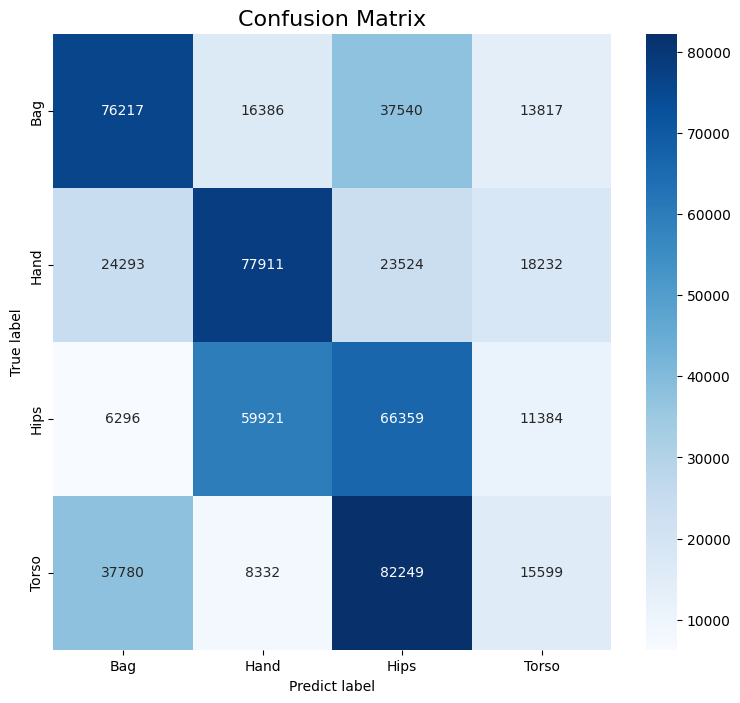

In [44]:
y_val1_pred = model_XGB1.predict(X_val).tolist()
evaluate(y_val1, y_val1_pred)

# 模型优化——只用步行数据

In [45]:
X_train_walk=X_train.loc[y_train[y_train['label']==2].index,:]
y_train_walk=y_train.loc[y_train[y_train['label']==2].index,'label_pos']
X_val_walk=X_val.loc[y_val[y_val['label']==2].index,:]
y_val_walk=y_val.loc[y_val[y_val['label']==2].index,'label_pos']

In [47]:
#打乱数据集顺序
X_train_walk,y_train_walk= shuffle(X_train_walk,y_train_walk,random_state=648)
X_val_walk,y_val_walk= shuffle(X_val_walk,y_val_walk,random_state=648)

In [48]:
model_XGB1_walking = xgb.XGBClassifier(learning_rate=0.01,
                                n_estimators=200,
                                gpu_id=0,
                                max_depth=8,
                                min_child_weight=1,
                                gamma=0,
                                colsample_bytree=0.85,
                                tree_method='gpu_hist')

In [49]:
model_XGB1_walking.fit(X_train_walk,y_train_walk)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.85, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

Macro F1 Score: 0.5056449778513445

              precision    recall  f1-score   support

         Bag       0.39      0.73      0.51     26148
        Hand       0.74      0.87      0.80     26148
        Hips       0.94      0.56      0.70     26148
       Torso       0.02      0.01      0.01     26148

    accuracy                           0.54    104592
   macro avg       0.52      0.54      0.51    104592
weighted avg       0.52      0.54      0.51    104592

[[19198  1720    18  5212]
 [ 2272 22779   756   341]
 [ 1918  6239 14659  3332]
 [25847    23   111   167]]


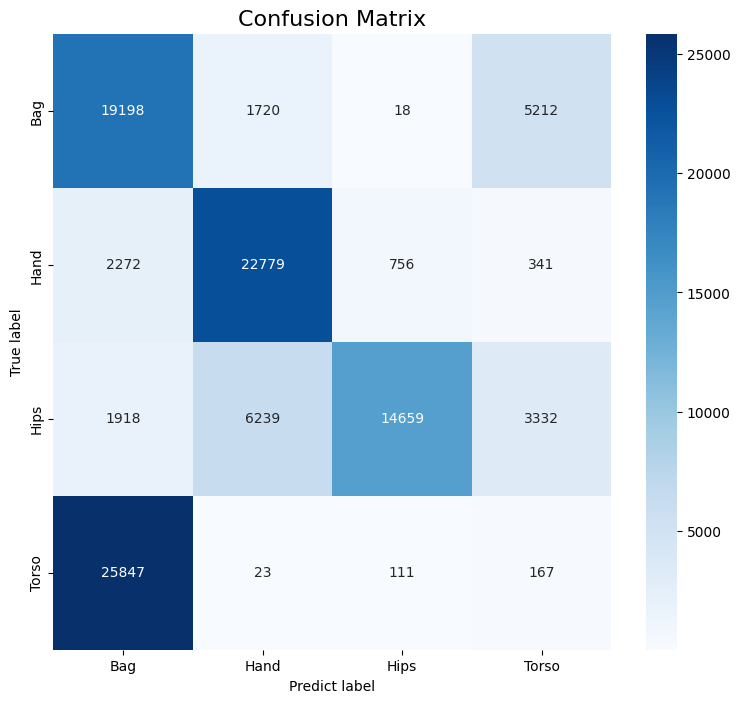

In [50]:
y_val_walk_pred = model_XGB1_walking.predict(X_val_walk).tolist()
evaluate(y_val_walk, y_val_walk_pred)

# 模型再优化——只使用验证集数据训练

In [51]:
X_val_train, X_val_test, y_val_train, y_val_test = train_test_split(X_val_walk, y_val_walk, test_size = 0.2, random_state = 111)

In [52]:
model_XGB2_walking = xgb.XGBClassifier(learning_rate=0.01,
                                n_estimators=200,
                                gpu_id=0,
                                max_depth=8,
                                min_child_weight=1,
                                gamma=0,
                                colsample_bytree=0.85,
                                tree_method='gpu_hist')

In [53]:
model_XGB2_walking.fit(X_val_train,y_val_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.85, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

Macro F1 Score: 0.9993757172764326

              precision    recall  f1-score   support

         Bag       1.00      1.00      1.00      5217
        Hand       1.00      1.00      1.00      5195
        Hips       1.00      1.00      1.00      5193
       Torso       1.00      1.00      1.00      5314

    accuracy                           1.00     20919
   macro avg       1.00      1.00      1.00     20919
weighted avg       1.00      1.00      1.00     20919

[[5211    6    0    0]
 [   7 5188    0    0]
 [   0    0 5193    0]
 [   0    0    0 5314]]


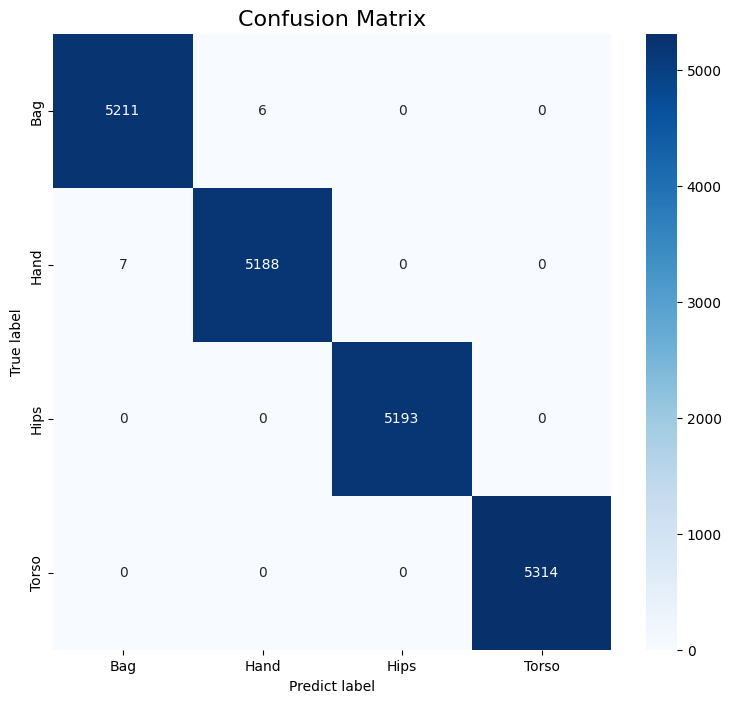

In [54]:
y_val_test_pred = model_XGB2_walking.predict(X_val_test).tolist()
evaluate(y_val_test, y_val_test_pred)

用于测试集位置预测

In [55]:
data3_1 = pd.read_pickle('/home/ossdata/dengjiebi/data_full/test/test_acc.pkl')
data3_2 = pd.read_pickle('/home/ossdata/dengjiebi/data_full/test/test_gps_and_loc.pkl')
data3_3 = pd.read_pickle('/home/ossdata/dengjiebi/data_full/test/test_gyr.pkl')
data3_4 = pd.read_pickle('/home/ossdata/dengjiebi/data_full/test/test_mag.pkl')
data3_5 = pd.read_pickle('/home/ossdata/dengjiebi/data_full/test/test_speed.pkl')
data3_6 = pd.read_pickle('/home/ossdata/dengjiebi/data_full/test/test_distance.pkl')

X_test=pd.concat([data3_1, data3_2,data3_3,data3_4,data3_5,data3_6],axis=1)
rename_columns(X_test,'test_')
X_test.head(5)

,acc_Acc_x,acc_Acc_y,acc_Acc_z,acc_L2,Mean_acc_Acc_x,Mean_acc_Acc_y,Mean_acc_Acc_z,Mean_acc_L2,Var_acc_Acc_x,Var_acc_Acc_y,...,vertical_speed_psd_value3,vertical_speed_psd_index1,vertical_speed_psd_index2,vertical_speed_psd_index3,railway_distances,living_street_distances,busway_distances,motorway_distances,residential_distances,pedestrian_distances
0,1.887083,4.855441,7.165227,8.858717,1.532213,3.960434,8.645449,10.147210,4.735924,2.689712,...,0.000392,16.0,12.0,8.0,76341.404,77645.880,108826.627,88650.667,75416.123,77289.567
1,3.446420,5.291521,12.328029,13.851293,1.435654,3.894931,8.689819,10.152433,4.867089,2.733063,...,0.000392,16.0,12.0,8.0,76341.080,77645.580,108826.312,88650.304,75415.807,77289.252
2,1.600775,5.773366,5.841525,8.367655,1.329650,3.819501,8.692287,10.119722,5.069665,2.826970,...,0.000392,16.0,12.0,8.0,76340.835,77645.355,108826.074,88650.025,75415.568,77289.014
3,2.806497,8.348034,-0.359370,8.814491,1.276330,3.721388,8.712358,10.097383,5.005058,3.056290,...,0.000392,16.0,12.0,8.0,76340.624,77645.165,108825.870,88649.774,75415.364,77288.810
4,2.374362,4.027273,10.380246,11.384464,1.188958,3.696198,8.719857,10.081729,5.112941,2.985250,...,0.000392,16.0,12.0,8.0,76340.383,77644.943,108825.635,88649.497,75415.129,77288.575


In [56]:
y_test_pred = model_XGB2_walking.predict(X_test).tolist()
dic = {'y_test_pred' : y_test_pred}
df_pos = pd.DataFrame(dic)
df_pos['y_test_pred'].value_counts()

y_test_pred
0    292839
1    139050
3     23171
2      8799
Name: count, dtype: int64

效果仍然不好，我们尝试只使用被预测为行走的数据进行预测

In [59]:
loaded_model = pickle.load(open("/home/ossdata/dengjiebi/model_final.pkl", "rb"))

In [60]:
y_test_pred = loaded_model.predict(X_test).tolist()

dic = {'label' : y_test_pred}
df_label = pd.DataFrame(dic)
df_label['label'].value_counts()

label
0    89586
6    78730
7    77714
1    75538
5    51795
3    48972
4    38468
2     3056
Name: count, dtype: int64

In [61]:
X_test_walking = X_test[df_label['label']==1]
y_test_walking_pred = model_XGB2_walking.predict(X_test_walking).tolist()

dic = {'y_test_walking_pred' : y_test_walking_pred}
df_pos = pd.DataFrame(dic)
df_pos['y_test_walking_pred'].value_counts()

y_test_walking_pred
1    70749
0     2912
3     1033
2      844
Name: count, dtype: int64

In [62]:
#计算比例
df_pos['y_test_walking_pred'].value_counts()/len(df_pos)

y_test_walking_pred
1    0.936601
0    0.038550
3    0.013675
2    0.011173
Name: count, dtype: float64

In [3]:
#0    292839/463859
#1    139050/463859
#3     23171/463859
#2      8799/463859
print(292839/463859)
print(139050/463859)
print(23171/463859)
print(8799/463859)

0.631310376644627
0.2997678173755387
0.04995267958582242
0.018969126394011975
